In [2]:
import sys, qiskit
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
import numpy as np, os
import qiskit.quantum_info as qi
from qsee.compilation.qsp import QuantumStatePreparation
from qsee.core import ansatz, state, measure
from qsee.backend import constant, utilities
from qsee.evolution import crossover, mutate, selection, threshold
from qsee.evolution.environment import EEnvironment, EEnvironmentMetadata
%load_ext autoreload
%autoreload 2

<img src = '../docs/compilation-design1.png' height ='500px'>
<img src = '../docs/compilation-design2.png' height ='500px'>

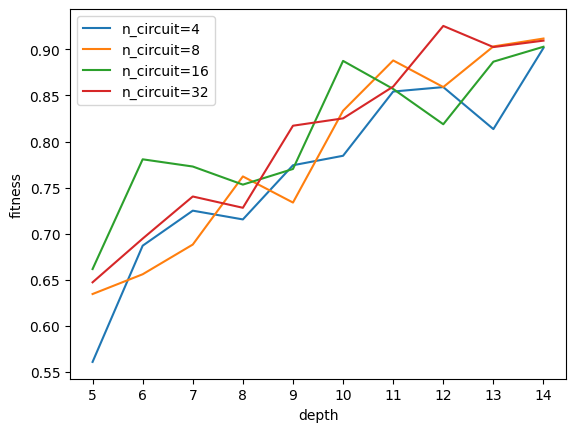

In [21]:
num_qubits = 3
num_circuit = 4
num_generation = 10
depths = range(5, 15)
# qubit = 2, depth = 4
# qubit = 3, depth around 15
# qubit = 4, depth around 40
# qubit = 5, depth around 100
# num_generation = 10, 20, 30, ...
# num_circuit = 4, 8, 16, 32, ...
# depth = 2,3,4, ...

# read all files metadata.json inside list of folders

for num_circuit in [4, 8, 16, 32]:
    best_fitness = []
    for depth in depths:
        envx = EEnvironment.load(f'n={num_qubits},d={depth},n_circuit={num_circuit},n_gen={num_generation}', None)
        best_fitness.append(np.max(envx.metadata.best_fitnesss))
    plt.plot(best_fitness, label=f'n_circuit={num_circuit}')
    
plt.ylabel('fitness')
plt.xlabel('depth')
plt.xticks(range(len(depths)), depths)
plt.legend()

In [3]:
# create an empty csv file has columns: n,depth,n_circuit,n_gen,risk
# n = 2,3,4,5,6
# depth = 2,3,4, ...
# n_circuit = 4,8,16,32, ...
# n_gen = 10,20,30, ...
# risk = 0.1,0.2,0.3, ...

def changeCost(n, d, n_circuit, n_gen, cost):
    df = pd.read_csv('risk.csv')
    filtered_df = df[(df['n'] == n) & (df['d'] == d) & (df['n_circuit'] == n_circuit) & (df['n_gen'] == n_gen)]
    row_index = filtered_df.index.tolist()[0]
    if df.loc[row_index]['cost'] == 0:
        df.loc[row_index] = [n, d, n_circuit, n_gen, df.loc[row_index]['risk'], cost]
        df.to_csv('risk.csv', index=False)
    return

import pandas as pd
import csv

ns = [2, 3, 4, 5, 6]
num_circuits = [4, 8, 16, 32]
num_generations = [10, 20, 30, 40, 50]
for n in ns:
    for n_circuit in num_circuits:
        for n_gen in num_generations:
            if n == 2:
                depths = list(range(2, 4))
            elif n == 3:
                depths = list(range(5, 15))
            elif n == 4:
                depths = list(range(10, 30))
            elif n == 5:
                depths = list(range(20, 50))
            elif n == 6:
                depths = list(range(30, 70))
            for d in depths:
                if os.path.isdir(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}'):
                    print(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}')
                    envx = EEnvironment.load(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}', None)
                    best_fitness = (np.max(envx.metadata.best_fitnesss))
                    changeCost(n, d, n_circuit, n_gen, best_fitness)


n=2,d=2,n_circuit=4,n_gen=10
n=2,d=3,n_circuit=4,n_gen=10
n=2,d=2,n_circuit=4,n_gen=20
n=2,d=3,n_circuit=4,n_gen=20
n=2,d=2,n_circuit=4,n_gen=30
n=2,d=3,n_circuit=4,n_gen=30
n=2,d=2,n_circuit=4,n_gen=40
n=2,d=3,n_circuit=4,n_gen=40
n=2,d=2,n_circuit=4,n_gen=50
n=2,d=3,n_circuit=4,n_gen=50
n=2,d=2,n_circuit=8,n_gen=10
n=2,d=3,n_circuit=8,n_gen=10
n=2,d=2,n_circuit=8,n_gen=20
n=2,d=2,n_circuit=8,n_gen=30
n=2,d=3,n_circuit=8,n_gen=30
n=2,d=2,n_circuit=8,n_gen=40
n=2,d=3,n_circuit=8,n_gen=40
n=2,d=2,n_circuit=8,n_gen=50
n=2,d=3,n_circuit=8,n_gen=50
n=2,d=2,n_circuit=16,n_gen=10
n=2,d=3,n_circuit=16,n_gen=10
n=2,d=2,n_circuit=16,n_gen=20
n=2,d=3,n_circuit=16,n_gen=20
n=2,d=2,n_circuit=16,n_gen=30
n=2,d=2,n_circuit=16,n_gen=40
n=2,d=3,n_circuit=16,n_gen=40
n=2,d=2,n_circuit=16,n_gen=50
n=2,d=3,n_circuit=16,n_gen=50
n=2,d=2,n_circuit=32,n_gen=10
n=2,d=3,n_circuit=32,n_gen=10
n=2,d=2,n_circuit=32,n_gen=20
n=2,d=3,n_circuit=32,n_gen=20
n=2,d=3,n_circuit=32,n_gen=30
n=2,d=2,n_circuit=32,n_gen=40

In [4]:
for n in ns:
    for n_circuit in num_circuits:
        for n_gen in num_generations:
            if n == 2:
                depths = list(range(2, 4))
            elif n == 3:
                depths = list(range(5, 15))
            elif n == 4:
                depths = list(range(10, 30))
            elif n == 5:
                depths = list(range(20, 50))
            elif n == 6:
                depths = list(range(30, 70))
            for d in depths:
                if os.path.isdir(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}') is False:
                    print(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}')

n=2,d=3,n_circuit=8,n_gen=20
n=2,d=3,n_circuit=16,n_gen=30
n=2,d=2,n_circuit=32,n_gen=30
n=2,d=3,n_circuit=32,n_gen=50
n=4,d=10,n_circuit=4,n_gen=10
n=4,d=11,n_circuit=4,n_gen=10
n=4,d=12,n_circuit=4,n_gen=10
n=4,d=13,n_circuit=4,n_gen=10
n=4,d=14,n_circuit=4,n_gen=10
n=4,d=18,n_circuit=4,n_gen=10
n=4,d=19,n_circuit=4,n_gen=10
n=4,d=20,n_circuit=4,n_gen=10
n=4,d=21,n_circuit=4,n_gen=10
n=4,d=22,n_circuit=4,n_gen=10
n=4,d=23,n_circuit=4,n_gen=10
n=4,d=24,n_circuit=4,n_gen=10
n=4,d=25,n_circuit=4,n_gen=10
n=4,d=26,n_circuit=4,n_gen=10
n=4,d=27,n_circuit=4,n_gen=10
n=4,d=28,n_circuit=4,n_gen=10
n=4,d=29,n_circuit=4,n_gen=10
n=4,d=10,n_circuit=4,n_gen=20
n=4,d=11,n_circuit=4,n_gen=20
n=4,d=12,n_circuit=4,n_gen=20
n=4,d=13,n_circuit=4,n_gen=20
n=4,d=14,n_circuit=4,n_gen=20
n=4,d=18,n_circuit=4,n_gen=20
n=4,d=19,n_circuit=4,n_gen=20
n=4,d=20,n_circuit=4,n_gen=20
n=4,d=21,n_circuit=4,n_gen=20
n=4,d=22,n_circuit=4,n_gen=20
n=4,d=23,n_circuit=4,n_gen=20
n=4,d=24,n_circuit=4,n_gen=20
n=4,d=25,n_

In [70]:

def testing(n, d, n_circuit, n_gen):
    m = 5
    utests = []
    print("Testing states:")
    for i in range(0, m):
        utest = state.haar(n)
        print(qi.Statevector.from_instruction(utest).data)
        utests.append(utest)
    def changeRisk(n, d, n_circuit, n_gen, risk):
        df = pd.read_csv('risk.csv')
        filtered_df = df[(df['n'] == n) & (df['d'] == d) & (df['n_circuit'] == n_circuit) & (df['n_gen'] == n_gen)]
        row_index = filtered_df.index.tolist()[0]
        df.loc[row_index] = [n, d, n_circuit, n_gen, risk, df.loc[row_index]['cost']]
        df.to_csv(f'risk{n}.csv', index=False)
        return
    def random_compiltion_test(qc_best: qiskit.QuantumCircuit):
        risks = []
        for i in range(0, m):
            qsp = QuantumStatePreparation(
                u=qc_best,
                target_state=utests[i].inverse()
            ).fit(num_steps=100)
            risks.append((measure.measure(utests[i]) - measure.measure(qc_best.assign_parameters(qsp.compiler.thetas)))**2)
        return np.mean(risks)/4
    env = EEnvironment.load(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}', None)
    # env = EEnvironment.load(f'n={2},d={2},n_circuit={4},n_gen={10}', None)
    risk = (random_compiltion_test(env.best_circuit))
    changeRisk(n, d, n_circuit, n_gen, risk)

ns = [2, 3, 4, 5, 6]
num_circuits = [4, 8, 16, 32]
num_generations = [10, 20, 30, 40, 50]
for n in ns:
    for n_circuit in num_circuits:
        for n_gen in num_generations:
            if n == 2:
                depths = list(range(2, 4))
            elif n == 3:
                depths = list(range(5, 15))
            elif n == 4:
                depths = list(range(10, 30))
            elif n == 5:
                depths = list(range(20, 50))
            elif n == 6:
                depths = list(range(30, 70))
            for d in depths:
                if os.path.isdir(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}'):
                    testing(n, d, n_circuit, n_gen)

Testing states:
[-0.64623177+7.91405673e-17j -0.34048773+4.16977207e-17j
 -0.41192346+5.04460752e-17j -0.54476753+6.67147810e-17j]
[-0.1089558 +2.66190043e-17j -0.2995635 +5.89326264e-17j
 -0.81304147+1.18151290e-16j  0.48718981+7.66416494e-17j]
[-0.15556641+1.90513901e-17j -0.59198578+7.24973490e-17j
  0.56811034-1.28959940e-33j  0.55009324-1.24870093e-33j]
[-0.55956265+6.85266605e-17j -0.64305608+7.87516570e-17j
  0.10514768-2.97258789e-34j  0.51216451-1.44791978e-33j]
[ 0.2839369 +7.30013540e-18j  0.40087134-2.09991600e-17j
 -0.86986835+3.06149706e-16j  0.04484487-2.58810273e-18j]
